In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import os
import torch

torch.cuda.set_device(1)
torch.cuda.current_device()

import warnings
from pathlib import Path
from wrappers.transformer_wrapper import FairseqTransformerHub
from wrappers.utils import *

import alignment.align as align

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger()

logger.setLevel('WARNING')
warnings.simplefilter('ignore')

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load model

In [6]:
data_sample = 'interactive' # generate/interactive
teacher_forcing = True # teacher forcing/free decoding

green_color = '#82B366'
red_color = '#B85450'

In [7]:
# Paths
europarl_dir = Path(os.environ['EUROPARL_DATA_DIR'])
ckpt_dir = Path(os.environ['EUROPARL_CKPT_DIR'])
#iwslt14_dir = Path(os.environ['IWSLT14_DATA_DIR'])
#ckpt_dir = Path(os.environ['IWSLT14_CKPT_DIR'])

# Choose model
model_type = 'baseline'
seed = 5498 # 2253  2453  5498  9240  9819

hub = FairseqTransformerHub.from_pretrained(
    ckpt_dir / f"{model_type}/{seed}",
    checkpoint_file=f"checkpoint_best.pt",
    data_name_or_path=(europarl_dir / "processed_data/fairseq_preprocessed_data").as_posix(), # processed data
    #(data_name_or_path=iwslt14_dir / "data-bin").as_posix(),
)
NUM_LAYERS = 6


## Get sample for analysis

In [44]:
if data_sample == 'interactive':
    # Get sample from Gold alignment dataset

    # index in dataset
    i = 105 # index in dataset
    # 3, 100, 105, 107, 120 (example paper), 163 (error visible)
    test_set_dir = europarl_dir / "processed_data/"
    src = "de"
    tgt = "en"
    tokenizer = "bpe"
    src_word_sent, src_tok, src_tok_str, src_tensor, tgt_word_sent, tgt_tok, tgt_tok_str, tgt_tensor = hub.get_interactive_sample(i, test_set_dir, src, tgt, tokenizer, hallucination=False)

    print(src_word_sent)
    print(tgt_word_sent)

wir benötigen detaillierte , konkrete vorschläge .

we need detailed , concrete proposals .



In [45]:
# Standard forward-pass
model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

print("\n\nGREEDY DECODING\n")
pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
orig_pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
print(f"Predicted sentence: \t {pred_sent}")
probs = torch.nn.functional.softmax(log_probs, dim=-1)
original_predictions = torch.max(probs,dim=-1)

source_sentence = src_tok
target_sentence = tgt_tok
predicted_sentence = orig_pred_tok
original_src_tensor = src_tensor
original_tgt_tensor = tgt_tensor
original_source_sentence = source_sentence
original_target_sentence = target_sentence
original_predictions



GREEDY DECODING

Predicted sentence: 	 we need detailed , concrete proposals .


torch.return_types.max(
values=tensor([0.8031, 0.8357, 0.8745, 0.7299, 0.7023, 0.8823, 0.9037, 0.9049],
       device='cuda:1'),
indices=tensor([ 171,  287, 3518,   17, 3004, 1031,   24,    2], device='cuda:1'))

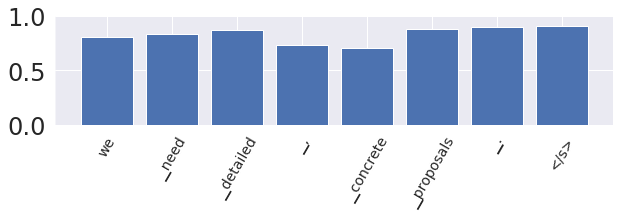

In [46]:
plt.figure(figsize=(10,2))

df_pred = pd.DataFrame(original_predictions.values, columns = ['probability'], index = predicted_sentence + ['</s>'])
#sns.set_style("white")
plt.bar(range(0,len(predicted_sentence + ['</s>'])), df_pred.probability, align='center')
plt.xticks(ticks = range(0,len(predicted_sentence + ['</s>'])) ,labels = predicted_sentence + ['</s>'],fontsize='14',rotation=60)
#plt.gca().invert_yaxis()
plt.grid(visible=True)
plt.ylim(0,1);

### ALTI of the entire model

In [47]:
total_rollout = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total']
contributions_rollout_layer = total_rollout[-1]

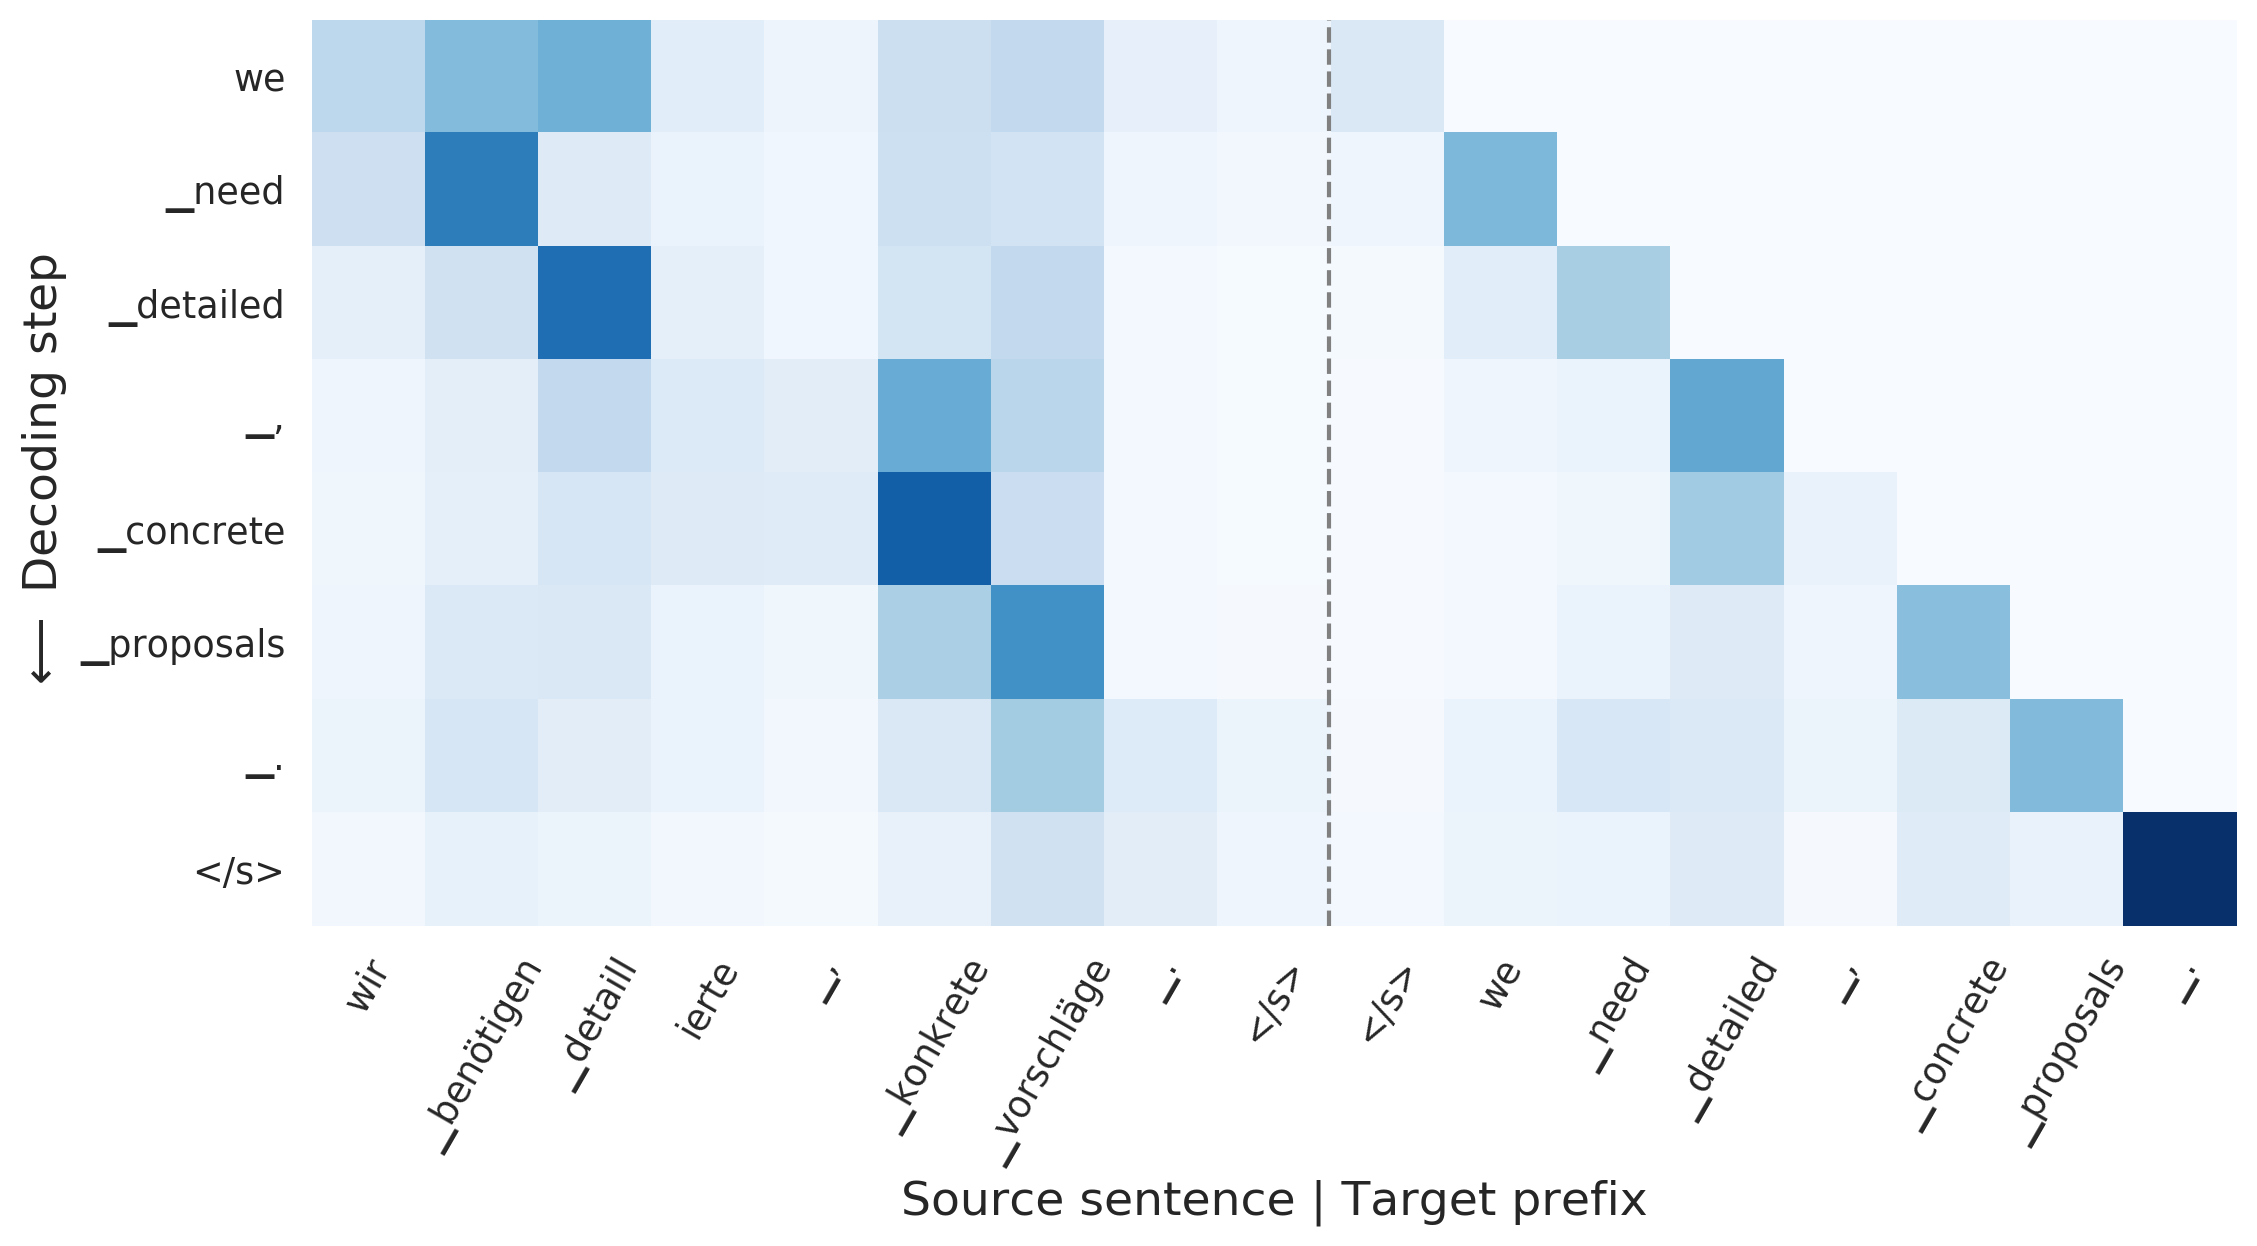

In [48]:
contributions_alti_layer_np = contributions_rollout_layer.detach().cpu().numpy()
plt.figure(figsize=(15,6),dpi=200)
df = pd.DataFrame(contributions_alti_layer_np, columns = source_sentence + ['</s>'] + ['</s>'] + target_sentence, index = predicted_sentence + ['</s>'])
sns.set(font_scale=1.2)
s = sns.heatmap(df,cmap="Blues",square=True, cbar=False)
s.set_xlabel('Source sentence | Target prefix', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)
plt.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15
plt.xticks(rotation=60);


## Deletion progression

In [49]:
#Ranking ALTI input attributions
from scipy.stats import rankdata

rank_total_alti = rankdata(contributions_alti_layer_np, method='dense', axis = -1)
arg_max_alti = np.argmax(rank_total_alti,axis=-1)

In [50]:
method = 'masking' # 'deletion', 'masking'

In [51]:
original_tgt_tensor

tensor([   2,  171,  287, 3518,   17, 3004, 1031,   24])

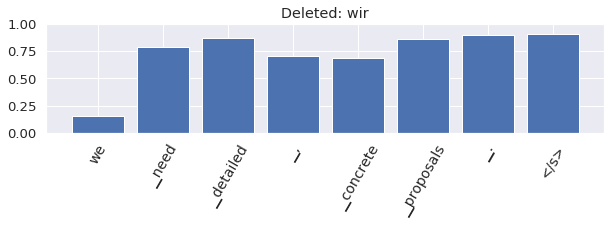

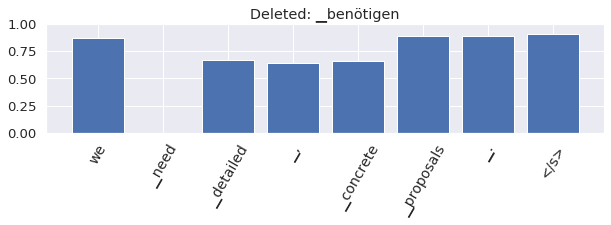

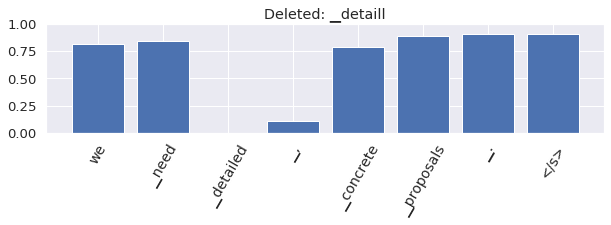

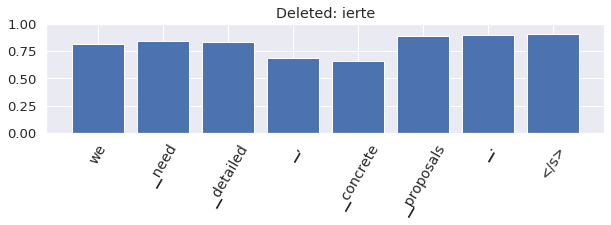

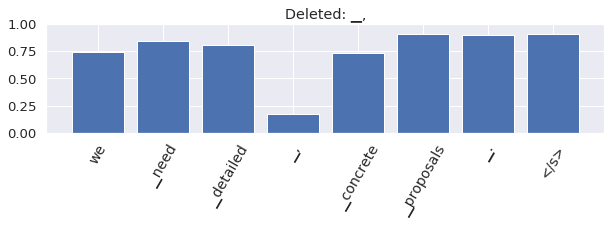

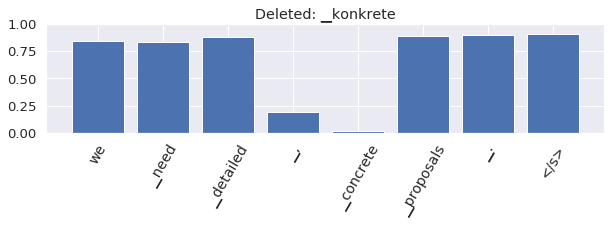

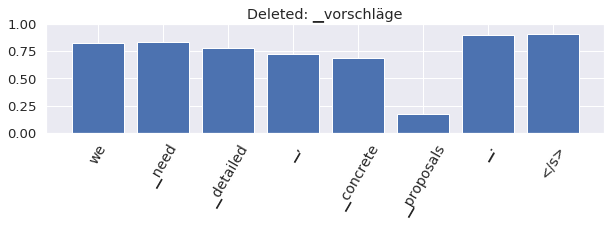

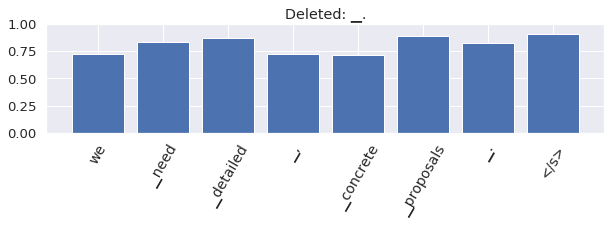

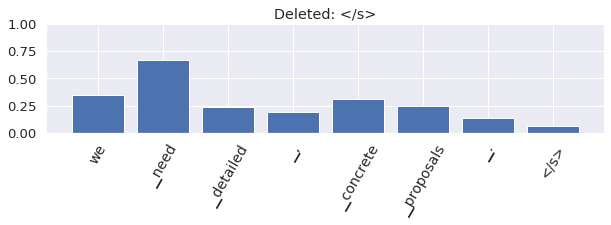

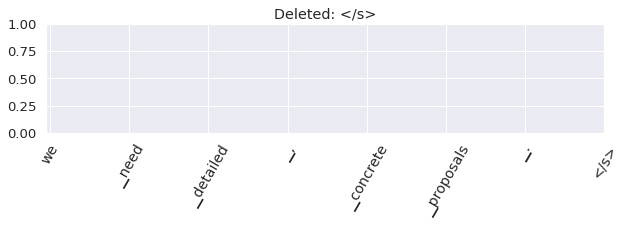

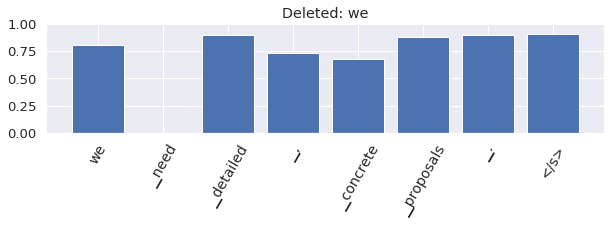

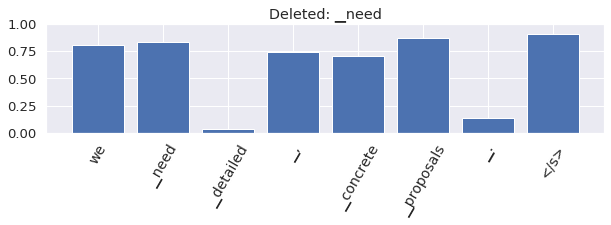

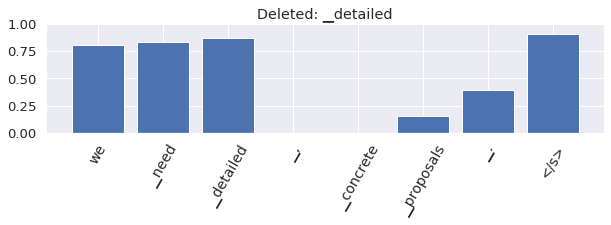

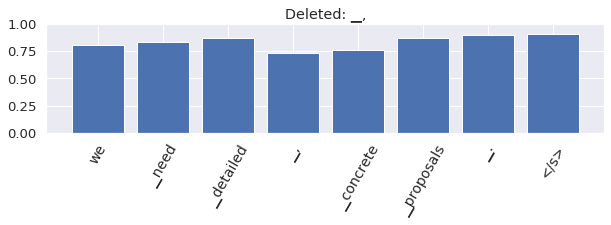

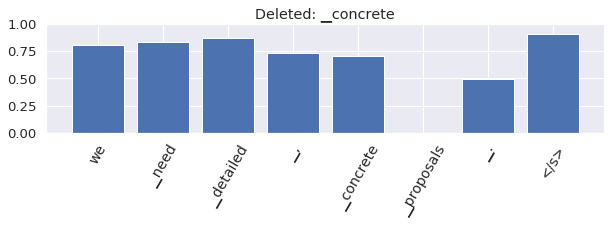

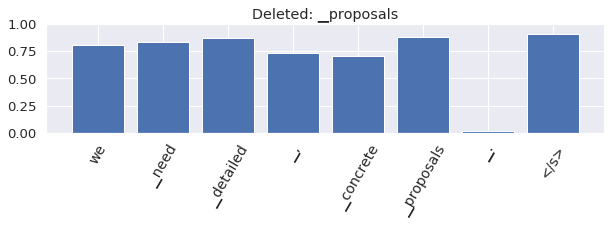

In [52]:
# Remove token

#dec_step = 5
for token_pos in range(len(original_source_sentence + ['</s>'] + ['</s>'] + original_target_sentence)-1):
    predicted_sentence = orig_pred_tok
    if token_pos == len(source_sentence + ['</s>'])+1:
        pass
#token_pos = 1
    if token_pos <= len(src_tok):
        tgt_tensor_del = original_tgt_tensor
        if method == 'deletion':
            src_tok_del = src_tok[:token_pos] + src_tok[token_pos+1:]
            src_tensor_del = torch.cat((src_tensor[:token_pos], src_tensor[token_pos+1:]))
            total_src = src_tok + ['</s>']
            tok_removed = total_src[token_pos]
        elif method == 'masking':
            src_tok_del = src_tok
            src_tensor_del = torch.cat((src_tensor[:token_pos],  torch.tensor(hub.task.source_dictionary.pad()).reshape(1), src_tensor[token_pos+1:]))
            total_src = src_tok + ['</s>']
            tok_removed = total_src[token_pos]

    else:
        token_pos_tgt = token_pos - (len(src_tok)+1)
        src_tensor_del = original_src_tensor
        if method == 'deletion':
            src_tok_del = src_tok
            tgt_tok_del = tgt_tok[:token_pos_tgt] + tgt_tok[token_pos_tgt+1:]
            tgt_tensor_del = torch.cat((original_tgt_tensor[:token_pos_tgt], original_tgt_tensor[token_pos_tgt+1:]))
            predicted_sentence = predicted_sentence[:token_pos_tgt] + predicted_sentence[token_pos_tgt+1:]
            total_tgt = ['</s>'] + tgt_tok#[token_pos]
            tok_removed = total_tgt[token_pos_tgt]
        elif method == 'masking':
            src_tok_del = src_tok
            tgt_tok_del = tgt_tok
            tgt_tensor_del = torch.cat((original_tgt_tensor[:token_pos_tgt],  torch.tensor(hub.task.target_dictionary.pad()).reshape(1), original_tgt_tensor[token_pos_tgt+1:]))
            total_tgt = ['</s>'] + tgt_tok#[token_pos]
            tok_removed = total_tgt[token_pos_tgt]

    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor_del, tgt_tensor_del)
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
    pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
    #print(f"Predicted sentence: \t {pred_tok}")

    probs = torch.nn.functional.softmax(log_probs, dim=-1)

    source_sentence = src_tok_del
    target_sentence = tgt_tok
    #predicted_sentence = pred_tok

    if token_pos <= len(src_tok):
        deleted_pred = probs[:,original_predictions.indices].diag()
    else:
        if method == 'deletion':
            pred_indices = torch.cat((original_predictions.indices[:token_pos_tgt], original_predictions.indices[token_pos_tgt+1:]))
        elif method == 'masking':
            pred_indices = original_predictions.indices
        deleted_pred = probs[:,pred_indices].diag()

    plt.figure(figsize=(10,2))

    df_pred = pd.DataFrame(deleted_pred, columns = ['probability'], index = predicted_sentence + ['</s>'])
    #sns.set_style("white")
    plt.bar(range(0,len(predicted_sentence + ['</s>'])), df_pred.probability, align='center')
    plt.xticks(ticks = range(0,len(predicted_sentence + ['</s>'])) ,labels = predicted_sentence + ['</s>'],fontsize='14',rotation=60)
    plt.title('Deleted: ' + tok_removed)
    #plt.gca().invert_yaxis()
    plt.grid(visible=True)
    plt.ylim(0,1);

    # total_rollout = hub.get_contribution_rollout(src_tensor_del, tgt_tensor_del, 'l1', norm_mode='min_sum')['total']
    # contributions_rollout_layer = total_rollout[-1]
    # contributions_alti_layer_np = contributions_rollout_layer.detach().cpu().numpy()
    # plt.figure(figsize=(15,6),dpi=200)
    # df = pd.DataFrame(contributions_alti_layer_np, columns = source_sentence + ['</s>'] + ['</s>'] + target_sentence, index = predicted_sentence + ['</s>'])
    # sns.set(font_scale=1.2)
    # s = sns.heatmap(df,cmap="Blues",square=True, cbar=False)
    # s.set_xlabel('Source sentence | Target prefix', fontsize=17)
    # s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)
    # plt.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15
    # plt.xticks(rotation=60);
    